<a href="https://colab.research.google.com/github/doublezz10/teaching_ANNs/blob/main/intro_to_ANNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Toward an intuitve understanding of neural networks

Assembled by Zach Zeisler

Most of the content comes from YouTube (3Blue1Brown) and Neuromatch Academy

None of the images or code are mine, but most of the text is unless specified.

## Goals


* Get some high-level understanding of the math that neural networks do without getting *lost in the weeds* of linear algebra
* Understand the roles of different layers, numbers of neurons, activation functions, and learning algorithms
* Explain backpropagation as the algorithm by which neural networks "learn"
* Build a simple multi-layer perceptron to decode visual stimuli from neural activity data
* Compare this simple network to some of its more complicated relatives


## Get set up

In [ ]:
#@title Import data, helper functions, etc.
#@markdown This will take a second :)

import os
import numpy as np

import torch
from torch import nn
from torch import optim

import matplotlib as mpl
from matplotlib import pyplot as plt

import hashlib
import requests

%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")

fname = "W3D4_stringer_oribinned1.npz"
url = "https://osf.io/683xc/download"
expected_md5 = "436599dfd8ebe6019f066c38aed20580"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    elif hashlib.md5(r.content).hexdigest() != expected_md5:
      print("!!! Data download appears corrupted !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

def load_data(data_name=fname, bin_width=1):
  """Load mouse V1 data from Stringer et al. (2019)

  Data from study reported in this preprint:
  https://www.biorxiv.org/content/10.1101/679324v2.abstract

  These data comprise time-averaged responses of ~20,000 neurons
  to ~4,000 stimulus gratings of different orientations, recorded
  through Calcium imaginge. The responses have been normalized by
  spontanous levels of activity and then z-scored over stimuli, so
  expect negative numbers. They have also been binned and averaged
  to each degree of orientation.

  This function returns the relevant data (neural responses and
  stimulus orientations) in a torch.Tensor of data type torch.float32
  in order to match the default data type for nn.Parameters in
  Google Colab.

  This function will actually average responses to stimuli with orientations
  falling within bins specified by the bin_width argument. This helps
  produce individual neural "responses" with smoother and more
  interpretable tuning curves.

  Args:
    bin_width (float): size of stimulus bins over which to average neural
      responses

  Returns:
    resp (torch.Tensor): n_stimuli x n_neurons matrix of neural responses,
        each row contains the responses of each neuron to a given stimulus.
        As mentioned above, neural "response" is actually an average over
        responses to stimuli with similar angles falling within specified bins.
    stimuli: (torch.Tensor): n_stimuli x 1 column vector with orientation
        of each stimulus, in degrees. This is actually the mean orientation
        of all stimuli in each bin.

  """
  with np.load(data_name) as dobj:
    data = dict(**dobj)
  resp = data['resp']
  stimuli = data['stimuli']

  if bin_width > 1:
    # Bin neural responses and stimuli
    bins = np.digitize(stimuli, np.arange(0, 360 + bin_width, bin_width))
    stimuli_binned = np.array([stimuli[bins == i].mean() for i in np.unique(bins)])
    resp_binned = np.array([resp[bins == i, :].mean(0) for i in np.unique(bins)])
  else:
    resp_binned = resp
    stimuli_binned = stimuli

  # Return as torch.Tensor
  resp_tensor = torch.tensor(resp_binned, dtype=torch.float32)
  stimuli_tensor = torch.tensor(stimuli_binned, dtype=torch.float32).unsqueeze(1)  # add singleton dimension to make a column vector

  return resp_tensor, stimuli_tensor


def plot_data_matrix(X, ax):
  """Visualize data matrix of neural responses using a heatmap

  Args:
    X (torch.Tensor or np.ndarray): matrix of neural responses to visualize
        with a heatmap
    ax (matplotlib axes): where to plot

  """

  cax = ax.imshow(X, cmap='viridis', vmin=np.percentile(X, 1), vmax=np.percentile(X, 99))
  cbar = plt.colorbar(cax, ax=ax, label='normalized neural response')

  ax.set_aspect('auto')
  ax.set_xticks([])
  ax.set_yticks([])


def identityLine():
  """
  Plot the identity line y=x
  """
  ax = plt.gca()
  lims = np.array([ax.get_xlim(), ax.get_ylim()])
  minval = lims[:, 0].min()
  maxval = lims[:, 1].max()
  equal_lims = [minval, maxval]
  ax.set_xlim(equal_lims)
  ax.set_ylim(equal_lims)
  line = ax.plot([minval, maxval], [minval, maxval], color="0.7")
  line[0].set_zorder(-1)

def get_data(n_stim, train_data, train_labels):
  """ Return n_stim randomly drawn stimuli/resp pairs

  Args:
    n_stim (scalar): number of stimuli to draw
    resp (torch.Tensor):
    train_data (torch.Tensor): n_train x n_neurons tensor with neural
      responses to train on
    train_labels (torch.Tensor): n_train x 1 tensor with orientations of the
      stimuli corresponding to each row of train_data, in radians

  Returns:
    (torch.Tensor, torch.Tensor): n_stim x n_neurons tensor of neural responses and n_stim x 1 of orientations respectively
  """
  n_stimuli = train_labels.shape[0]
  istim = np.random.choice(n_stimuli, n_stim)
  r = train_data[istim]  # neural responses to this stimulus
  ori = train_labels[istim]  # true stimulus orientation

  return r, ori

def stimulus_class(ori, n_classes):
  """Get stimulus class from stimulus orientation

  Args:
    ori (torch.Tensor): orientations of stimuli to return classes for
    n_classes (int): total number of classes

  Returns:
    torch.Tensor: 1D tensor with the classes for each stimulus

  """
  bins = np.linspace(0, 360, n_classes + 1)
  return torch.tensor(np.digitize(ori.squeeze(), bins)) - 1  # minus 1 to accomodate Python indexing

def plot_decoded_results(train_loss, test_labels, predicted_test_labels):
  """ Plot decoding results in the form of network training loss and test predictions

  Args:
    train_loss (list): training error over iterations
    test_labels (torch.Tensor): n_test x 1 tensor with orientations of the
      stimuli corresponding to each row of train_data, in radians
    predicted_test_labels (torch.Tensor): n_test x 1 tensor with predicted orientations of the
      stimuli from decoding neural network

  """

  # Plot results
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

  # Plot the training loss over iterations of GD
  ax1.plot(train_loss)

  # Plot true stimulus orientation vs. predicted class
  ax2.plot(stimuli_test.squeeze(), predicted_test_labels, '.')

  ax1.set_xlim([0, None])
  ax1.set_ylim([0, None])
  ax1.set_xlabel('iterations of gradient descent')
  ax1.set_ylabel('negative log likelihood')
  ax2.set_xlabel('true stimulus orientation ($^o$)')
  ax2.set_ylabel('decoded orientation bin')
  ax2.set_xticks(np.linspace(0, 360, n_classes + 1))
  ax2.set_yticks(np.arange(n_classes))
  class_bins = [f'{i * 360 / n_classes: .0f}$^o$ - {(i + 1) * 360 / n_classes: .0f}$^o$' for i in range(n_classes)]
  ax2.set_yticklabels(class_bins);

  # Draw bin edges as vertical lines
  ax2.set_ylim(ax2.get_ylim())  # fix y-axis limits
  for i in range(n_classes):
    lower = i * 360 / n_classes
    upper = (i + 1) * 360 / n_classes
    ax2.plot([lower, lower], ax2.get_ylim(), '-', color="0.7", linewidth=1, zorder=-1)
    ax2.plot([upper, upper], ax2.get_ylim(), '-', color="0.7", linewidth=1, zorder=-1)

  plt.tight_layout()

###What kind of data are we working with?

This data is from Carsen Stringer's paper on BioRxiv, linked [here](https://www.biorxiv.org/content/10.1101/679324v2). Headfixed mice were able to run in place on an air-floating ball while static gratings (1-360&deg;, 1&deg; gradations) were presented to the L eye for 750ms in a random order. While not an incredibly interesting setup, they were able to obtain a lot of data.

Neural activity was measured with multi-plane calcium imaging, and over 20k neurons were able to be identified. Activity in each neuron was binned and averaged across the presentation of each stimulus. 
<p align="center">
  <img src="https://i.imgur.com/TsuJdAh.png" width="850" />
</p>


23589 neurons in response to 360 stimuli


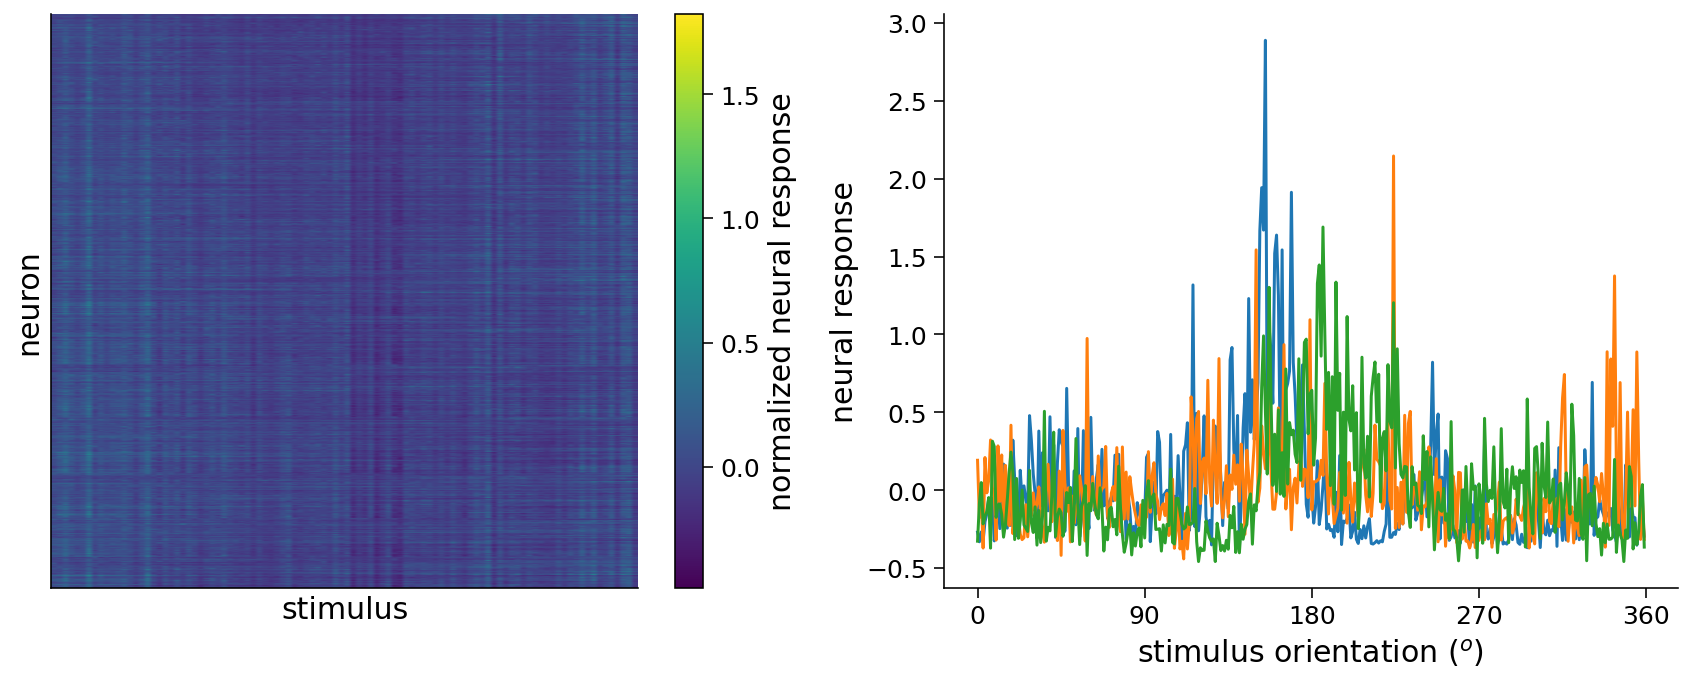

In [ ]:
#@title Data summary

# Load data
resp_all, stimuli_all = load_data()  # argument to this function specifies bin width
n_stimuli, n_neurons = resp_all.shape

print(f'{n_neurons} neurons in response to {n_stimuli} stimuli')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(2 * 6, 5))

# Visualize data matrix
plot_data_matrix(resp_all[:100, :].T, ax1)  # plot responses of first 100 neurons
ax1.set_xlabel('stimulus')
ax1.set_ylabel('neuron')

# Plot tuning curves of three random neurons
ineurons = np.random.choice(n_neurons, 3, replace=False)  # pick three random neurons
ax2.plot(stimuli_all, resp_all[:, ineurons])
ax2.set_xlabel('stimulus orientation ($^o$)')
ax2.set_ylabel('neural response')
ax2.set_xticks(np.linspace(0, 360, 5))

plt.tight_layout()

## Intro to (decoding) neural networks

<p align="center">
  <img src="https://github.com/NeuromatchAcademy/course-content/blob/master/tutorials/static/one-layer-network.png?raw=true" width="450" />
</p>

Above is a generalized model of how a network with one so-called *hidden layer* might be organized for this dataset. Each real neuron's response to a particular stimulus is z-scored and attributed to one neuron in the input layer, here denoted as **r**. Each input neuron is connected to every neuron in the next layer, with connectivity specified by the weight matrix **w**; the activity in **r** is multiplied by its corresponding weight **w** and then fed into an activation function, two examples of which are below: sigmoid and ReLU. These generally non-linear functions serve to make the network more flexible (I'm not sure exactly what this means tbh). ReLU is viewed as a more biologically plausible mechanism as its activity doesn't saturate at high inputs.

<p align="center">
  <img src="https://miro.medium.com/max/1452/1*XxxiA0jJvPrHEJHD4z893g.png" width="550" />
</p>

Below is the total computation that is performed going from the input layer to the hidden layer. Bias terms can be added here to control for baseline neural activity.

<p align="center">
  <img src="https://i.imgur.com/PvKJvHC.png" width="550" />
</p>

Generally, when starting a new neural network, all of the weights and biases are totally random. We can set this up using PyTorch below.

# Our first network (with no learning)

In [ ]:
#@title Execute this cell to split data into training and test sets
#@markdown We'll use this to assess the accuracy of our network.

# Set random seeds for reproducibility
np.random.seed(4)
torch.manual_seed(4)

# Split data into training set and testing set
n_train = int(0.6 * n_stimuli)  # use 60% of all data for training set
ishuffle = torch.randperm(n_stimuli)
itrain = ishuffle[:n_train]  # indices of data samples to include in training set
itest = ishuffle[n_train:]  # indices of data samples to include in testing set
stimuli_test = stimuli_all[itest]
resp_test = resp_all[itest]
stimuli_train = stimuli_all[itrain]
resp_train = resp_all[itrain]

## Set up the class for the network

The exact syntax of this PyTorch instantiation is obviously not the point here. But, we can gain some simple intution about what it's doing regardless of how much Python we know.

**def init**: set up the number of layers and units in each layer; here, we have an imput layer that has the same number of neurons as were recorded in the dataset which is connected to a hidden layer. The hidden layer then has a single output, which will be the decoded orientation.

**def forward**: this describes the relationship between the layers (i.e. how is data passed *forward* through the network); in this simple example, all this says is that the input layer accepts neural data and outputs to the hidden layer, then that the output y is the output of the hidden layer.

In [ ]:
class DeepNet(nn.Module):
  """Deep Network with one hidden layer

  Args:
    n_inputs (int): number of input units
    n_hidden (int): number of units in hidden layer

  Attributes:
    in_layer (nn.Linear): weights and biases of input layer
    out_layer (nn.Linear): weights and biases of output layer

  """

  def __init__(self, n_inputs, n_hidden):
    super().__init__()  # needed to invoke the properties of the parent class nn.Module
    self.in_layer = nn.Linear(n_inputs, n_hidden) # neural activity --> hidden units
    self.out_layer = nn.Linear(n_hidden, 1) # hidden units --> output

  def forward(self, r):
    """Decode stimulus orientation from neural responses

    Args:
      r (torch.Tensor): vector of neural responses to decode, must be of
        length n_inputs. Can also be a tensor of shape n_stimuli x n_inputs,
        containing n_stimuli vectors of neural responses

    Returns:
      torch.Tensor: network outputs for each input provided in r. If
        r is a vector, then y is a 1D tensor of length 1. If r is a 2D
        tensor then y is a 2D tensor of shape n_stimuli x 1.

    """
    h = self.in_layer(r)  # hidden representation
    y = self.out_layer(h)
    return y

## Initialize the network

Here, with no training, we'll implement our network. The input to the network is the z-scored responses to one stimulus, and the output is the decoded stimulus orientation. It will be very clear that our network is useless at this point.

In [ ]:
# Set random seeds for reproducibility
np.random.seed(1)
torch.manual_seed(1)

# Initialize a deep network with M=200 hidden units
net = DeepNet(n_neurons, 200)

# Get neural responses (r) to and orientation (ori) to one stimulus in dataset
r, ori = get_data(1, resp_train, stimuli_train)  # using helper function get_data

# Decode orientation from these neural responses using initialized network
out = net(r)  # compute output from network, equivalent to net.forward(r)

print('decoded orientation: %.2f degrees' % out)
print('true orientation: %.2f degrees' % ori)

decoded orientation: 0.08 degrees
true orientation: 139.00 degrees


## Let's add an activation function (here ReLU)

Spoiler: the model is still useless because it hasn't been trained.

In [ ]:
class DeepNetReLU(nn.Module):

  def __init__(self, n_inputs, n_hidden):
    super().__init__()  # needed to invoke the properties of the parent class nn.Module
    self.in_layer = nn.Linear(n_inputs, n_hidden) # neural activity --> hidden units
    self.out_layer = nn.Linear(n_hidden, 1) # hidden units --> output

  def forward(self, r):

    h = torch.relu(self.in_layer(r)) # PyTorch has the ReLU fxn built in
    y = self.out_layer(h)

    return y


# Set random seeds for reproducibility
np.random.seed(1)
torch.manual_seed(1)

# Get neural responses (r) to and orientation (ori) to one stimulus in dataset
r, ori = get_data(1, resp_train, stimuli_train)


# Initialize deep network with M=20 hidden units and uncomment lines below
net = DeepNetReLU(n_neurons, 20)

# Decode orientation from these neural responses using initialized network
# net(r) is equivalent to net.forward(r)
out = net(r)

print('decoded orientation: %.2f degrees' % out)
print('true orientation: %.2f degrees' % ori)

decoded orientation: 0.13 degrees
true orientation: 139.00 degrees


# Let's train our network!

*This section is copied directly from NMA as I liked the way they explained it*

Because the weights of the network are currently randomly chosen, the outputs of the network are nonsense: the decoded stimulus orientation is nowhere close to the true stimulus orientation. We'll shortly write some code to change these weights so that the network does a better job of decoding.

But to do so, we first need to define what we mean by "better". One simple way of defining this is to use the squared error
\begin{equation}
    L = (y - \tilde{y})^2
\end{equation}
where $y$ is the network output and $\tilde{y}$ is the true stimulus orientation. When the decoded stimulus orientation is far from the true stimulus orientation, $L$ will be large. We thus refer to $L$ as the **loss function**, as it quantifies how *bad* the network is at decoding stimulus orientation.

PyTorch actually carries with it a number of built-in loss functions. The one corresponding to the squared error is called `nn.MSELoss()`. This will take as arguments a **batch** of network outputs $y_1, y_2, \ldots, y_P$ and corresponding target outputs $\tilde{y}_1, \tilde{y}_2, \ldots, \tilde{y}_P$, and compute the **mean squared error (MSE)**
\begin{equation}
    L = \frac{1}{P}\sum_{n=1}^P \left(y^{(n)} - \tilde{y}^{(n)}\right)^2
\end{equation}

*I wrote this next part*

It's important to note that the loss function we're using here is the **mean** squared error. By optimizing the network this way, we're ensuring that the network can accurately predict values across the whole range of stimulus orientations.


In [ ]:
# Set random seeds for reproducibility
np.random.seed(1)
torch.manual_seed(1)

# Initialize a deep network with M=20 hidden units
net = DeepNetReLU(n_neurons, 20)

# Get neural responses to first 20 stimuli in the data set
r, ori = get_data(20, resp_train, stimuli_train)

# Decode orientation from these neural responses
out = net(r)

# Initialize PyTorch mean squared error loss function (Hint: look at nn.MSELoss)
loss_fn = nn.MSELoss()

# Evaluate mean squared error
loss = loss_fn(out, ori)

print('mean squared error: %.2f' % loss)

mean squared error: 42943.75


## Let's use stochastic gradient descent optimize the network by minimizing our MSE

<p align="center">
  <img src="https://rasbt.github.io/mlxtend/user_guide/general_concepts/gradient-optimization_files/ball.png" width="550" />
</p>

Here's how this works. For a given weight **w**, the cost associated with that weight can be computed (for us here, this is the mean squared error value). Using some fun linear algebra magic, the gradient can be computed (this is essentially the derivative at this point). Based on the sign of the slope of the gradient, the algorithm can determine which direction approaches the nearest local minimum; then, the algorithm makes incremental steps toward that minimum based on some learning rate (so each step isnt too big).

To optimize the whole network, PyTorch does this for every single weight, and averages the suggested steps across every training example. You can easily imagine that this becomes quite computationally intense when there are many thousands of training examples, which is where the stochastic in SGD comes in. Instead of doing this for every training example, PyTorch will randomly choose a subset of training examples and run SGD only on those; after multiple iterations, you generally arrive where you should - even if it looks a bit zig-zaggy.

<p align="center">
  <img src="https://i.imgur.com/8GhLbE4.png" width="400" />
</p>

This process of optimization is often referred to as backpropagation, as the model first optimizes the weights between the final two layers, then moves "backwards" to optimize the weights in the preceding layers. Information also is thought to flow backwards since you are starting from your cost function (MSE), which is course based on the outputs, and working through the network in the opposite direction that information usually flows.

Below, see how we can train our network using a SGD optimizer. Again, the logic of the PyTorch notation is not important here.


iteration 10/50 | loss: 11225.866
iteration 20/50 | loss: 796.539
iteration 30/50 | loss: 449.642
iteration 40/50 | loss: 285.460
iteration 50/50 | loss: 186.747


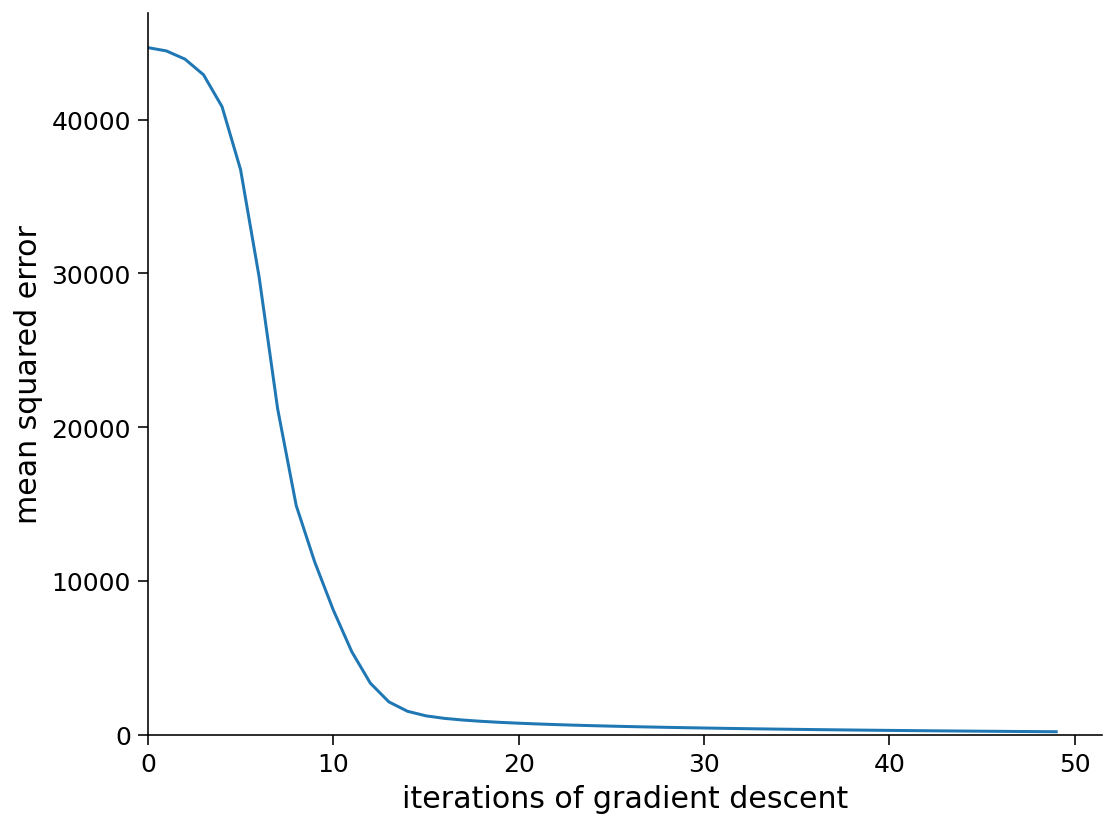

In [ ]:
def train(net, loss_fn, train_data, train_labels, n_iter=50, learning_rate=1e-4):
  """Run gradient descent to opimize parameters of a given network

  Args:
    net (nn.Module): PyTorch network whose parameters to optimize
    loss_fn: built-in PyTorch loss function to minimize
    train_data (torch.Tensor): n_train x n_neurons tensor with neural
      responses to train on
    train_labels (torch.Tensor): n_train x 1 tensor with orientations of the
      stimuli corresponding to each row of train_data, in radians
    n_iter (int): number of iterations of gradient descent to run
    learning_rate (float): learning rate to use for gradient descent

  """

  # Initialize PyTorch SGD optimizer
  optimizer = optim.SGD(net.parameters(), lr=learning_rate)

  # Placeholder to save the loss at each iteration
  track_loss = []

  # Loop over epochs (cf. appendix)
  for i in range(n_iter):

    # Evaluate loss using loss_fn
    out = net(train_data)  # compute network output from inputs in train_data
    loss = loss_fn(out, train_labels)  # evaluate loss function

    # Compute gradients
    optimizer.zero_grad()
    loss.backward()

    # Update weights
    optimizer.step()

    # Store current value of loss
    track_loss.append(loss.item())  # .item() needed to transform the tensor output of loss_fn to a scalar

    # Track progress
    if (i + 1) % (n_iter // 5) == 0:
      print(f'iteration {i + 1}/{n_iter} | loss: {loss.item():.3f}')

  return track_loss

# Set random seeds for reproducibility
np.random.seed(1)
torch.manual_seed(1)

# Initialize network
net = DeepNetReLU(n_neurons, 20)

# Initialize built-in PyTorch MSE loss function
loss_fn = nn.MSELoss()

# Run GD on data
train_loss = train(net, loss_fn, resp_train, stimuli_train)

# Plot the training loss over iterations of GD
plt.plot(train_loss)
plt.xlim([0, None])
plt.ylim([0, None])
plt.xlabel('iterations of gradient descent')
plt.ylabel('mean squared error')
plt.show()

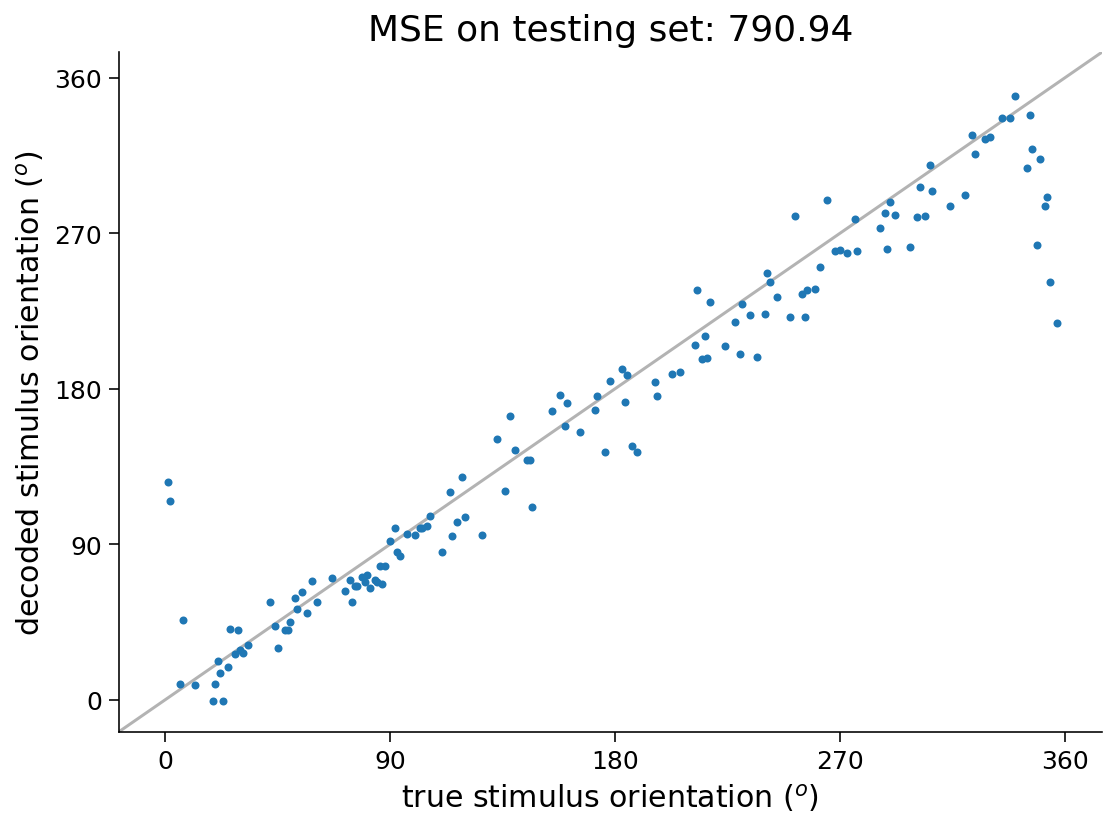

In [ ]:
#@title Let's see how we did
#@markdown Execute this cell to evaluate and plot test error

out = net(resp_test)  # decode stimulus orientation for neural responses in testing set
ori = stimuli_test  # true stimulus orientations
test_loss = loss_fn(out, ori)  # MSE on testing set (Hint: use loss_fn initialized in previous exercise)

plt.plot(ori, out.detach(), '.')  # N.B. need to use .detach() to pass network output into plt.plot()
identityLine()  # draw the identity line y=x; deviations from this indicate bad decoding!
plt.title('MSE on testing set: %.2f' % test_loss.item())  # N.B. need to use .item() to turn test_loss into a scalar
plt.xlabel('true stimulus orientation ($^o$)')
plt.ylabel('decoded stimulus orientation ($^o$)')
axticks = np.linspace(0, 360, 5)
plt.xticks(axticks)
plt.yticks(axticks)
plt.show()

We can see that besides having some issues around the 0 and 360 points, our model seems to predict with reasonable accuracy the orientation of the visual stimulus using the activity of over 20k neurons. If you feel like it, you could try messing around with the numbers of neurons in each layer in the code above to see how performance changes - but we can see that it does pretty well already.

Using a more complex loss function that knows that 0&deg; and 360&deg; are the same and that 1&deg; and 359&deg; are very close to each other, it would not be too tricky to make this network's performance even better.

This method of optimization is referred to as **supervised learning**, as we provided the network with both the inputs and the correct outputs. 

One could imagine a network that is trained under a **reinforcement learning** algorithm, where the choices/decisions determine the amount of "reward" at the end of each trial; the network thus aims to maximize the amount of reward.

The third and final kind of learning algorithm is **unsupervised learning**, where the network is provided with only the inputs and then is allowed to "do whatver it wants," without an objective or loss function to guide its parameters.

# Variations on this theme

<p align="center">
  <img src="https://els-jbs-prod-cdn.jbs.elsevierhealth.com/cms/attachment/cb8aed99-35a4-41dd-9d40-b7925ad49394/gr2.jpg" width="800" />
</p>

This figure is from [this](https://doi.org/10.1016/j.neuron.2020.09.005) primer; here are shown 4 different kinds of neural networks that are often used for different purposes.

In **A** is the simplest kind of network, which looks a lot like what we just built. Some series of inputs is processed by a number of layers, eventually resulting in some kind of output. Some people like to call this a "multi-layer perceptron." These have been around for a long time now. They are often viewed as a *black box*, as there is also no time component here; so inputs instantly become outputs after the network has been trained.

**B** is an example of a recurrent neural network. The general principle is the same: give it data, it does some fancy linear algebra, and spits out different data. Of course the architecture or structure of how the units are connected to one another is vastly different than what we were just working with. The connections in this network don't have to be one-to-one nor as "linear" in direction as the network in A. These are the kinds of networks that Kanaka's group builds and studies (an example of which is shown below, from their recent [review](https://doi-org.eresources.mssm.edu/10.1016/j.conb.2020.11.003)). Importantly, these networks also process information in time, so they can be analysed more similarly to brains (activity of "units", etc.) than perceptrons.

<p align="center">
  <img src="https://i.imgur.com/x5va3ll.jpg"width="600" />
</p>


**C** dives a bit into the math that the model in B might be doing. Each gray box is a different point in time, and *c* and *r* represent the current state and corresponding output of the network at each time *t*. *x* is the input to the system that drives the change between states.

**D** illustrates what a convolutional neural network does. To try to simplify how it works, I like to think of it like the visual system; this analogy is especially relevant since these networks are often used for computer vision and image classification. Each "neuron" in a channel has a particular "receptive field" called a kernel. The dimensions of this kernel determine the size of the "receptive field" for each unit. The kernel then slides along the image being processed in a moving window fashion. The weights of the network are shared amongst all of the units and tell each neuron which parts of its "receptive field" to care about. Below is an example of a simple 2D gaussian, which would tell the network that the center of the "receptive field" should be weighted more highly than the outside.

<p align="center">
  <img src="http://campar.in.tum.de/twiki/pub/Chair/HaukeHeibelGaussianDerivatives/gauss2d00.png"width="400" />
</p>

Each channel or layer of the network will have different kernel sizes and weight functions to detect different features of the image being processed. Put together, all of these convolutional layers generally feed into some kind of pooling layer, which then is connected to an output layer. Below is an example from Neuromatch Academy of how this might work (without the pooling layer). Note that this network goes in the opposite direction of the one we built above, as it takes the stimulus presented as an imput and tries to predict the neural activity.

<p align="center">
  <img src="https://github.com/NeuromatchAcademy/course-content/blob/master/tutorials/static/conv_fc.PNG?raw=true" width="800" />
</p>

In a convolutional neural network trained to identify handwritten digits from the MNIST dataset (which machine learning folks love), one can examine the responses of layers in the network (A: 2 convolutional layers, 2 fully connected layers, 1 output layer). 

B shows responses of neurons to each of the 10 digits in 2 of the layers.

C shows individual neurons' "receptive fields." Layers 1 & 2 show spatial locations as they're convolutional layers, while 3 & 4 are not convolutional and this show no spatial organization.

<p align="center">
  <img src="https://ars.els-cdn.com/content/image/1-s2.0-S0896627320307054-gr4.jpg"width="600" />
</p>

(Image from [this](https://www.sciencedirect.com/science/article/pii/S0896627320307054) primer)


It's a more complicated version of a ConvNet like this that underlies [DeepLabCut](https://www.nature.com/articles/s41593-018-0209-y) (shown below). ResNet-50 is a specific network architecture (containing 50 layers), and ImageNet is a standardized training set with nearly 15 million labelled images. Then, the deconvolution layers replace the detected points (arms, legs, head, etc.) back on the original video to allow tracking.

<p align="center">
  <img src="https://i.imgur.com/i0e7ecf.png"width="400" />
</p>


# More info

This was a "quick and dirty" intro to the land of neural networks. If you are interested in more reading (or video watching), here are some links to resources I used when putting this together.

Neuromatch Academy had two full days of neural network and deep learning content, complete with videos and Colab notebook tutorials. Day 1 and Day 2 notebooks are [here](https://github.com/NeuromatchAcademy/course-content/tree/master/tutorials/W3D4_DeepLearning1) and [here](https://github.com/NeuromatchAcademy/course-content/tree/master/tutorials/W3D5_DeepLearning2), and YouTube playlists for the accompanying videos are [here](https://www.youtube.com/playlist?list=PLkBQOLLbi18PZ2uw0p7G4EkzjzqP8l0Eg) and [here](https://www.youtube.com/playlist?list=PLkBQOLLbi18Ojl1CV8W00JZ0C0hivBxw1).

[Link](https://www.youtube.com/playlist?list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi): 3Blue1Brown's YouTube playlist of neural network videos. 3 videos about 20 min each. A bit more math than necessary but well-explained.

[Link](https://www.sciencedirect.com/science/article/pii/S0896627320307054): *Artificial Neural Networks for Neuroscientists: A Primer*. They also have a [GitHub repo](https://github.com/gyyang/nn-brain) with tutorial notebooks, but they aren't super well annotated to help understand what's going on.

A lot of online resources are not appropriate for our understanding of ANNs. Either they are too deep in the math that it is impossible to understand the general principles, or too deep in Python syntax to intuitively understand what's happening. Resources by machine learning or AI people tend to tout these as magic, when in reality they're quite simple :)